In [12]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
from aif360.metrics import BinaryLabelDatasetMetric
import jax
from flax.linen import relu
from flax.linen.initializers import kaiming_uniform

from utils import compute_ceop_output, get_model_prediction_dataframes, get_ground_truth_dataframes, create_aif360_dataset
from eop import EOP_Handler
from ceop import CEOP_Handler

import os, sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

from neural_network_analysis.src.utils import load_weights # type: ignore
from neural_network_analysis.src.models import WineQualityNetwork, create_model # type: ignore
from neural_network_analysis.src.data_loaders import load_wine_quality # type: ignore

In the following cell you can choose between the protected attributes (only one in this case for demonstration purposes) and which constraint to use for the calibrated equalized odds method.

We wanted to present how to use a custom model and dataset with AIF360, so we implemented the wine quality dataset and model from the initialization group. 

One caveat of this is that the wine dataset is actually not very suited for a fairness analysis, which needs a (sensitive) protected attributed, and binary, instead of one hot encoded or normalized feature values. Therefore we had to fudge the numbers a bit and "binarize" the label and a priviliged "group. 

This means that the output datasets of our models are not as good as they could've been for a more well suited dataset. Additionally, the wine quality assessment now being fair in regards to residual sugar does not seem as useful as making a credit score prediction more fair in regards to gender or age. 

Nevertheless, the models do perform their purpose well and we think that this is a useful demonstration for how to use the AIF360 tool with your own dataset and model.

In [13]:
cost_constraint = "fpr"  # "fnr", "fpr", "weighted"
privileged_groups, unprivileged_groups = [{'residual sugar': 1}], [{'residual sugar': 0}]
randseed = 12345679

In [14]:
# load model
wine_model, _ = create_model(
    WineQualityNetwork,
    jax.random.PRNGKey(42),
    input_shape=(1, 11),
    init_func=kaiming_uniform(),
    activation_func=relu,
)

# create weight dictionary
wine_weights = {
    0: load_weights(
        f"../neural_network_analysis/model_checkpoints/wine_quality/kaiming_uniform/relu/initial_weights.pkl"
    ),
    1: load_weights(
        f"../neural_network_analysis/model_checkpoints/wine_quality/kaiming_uniform/relu/best_weights.pkl"
    ),
    2: load_weights(
        f"../neural_network_analysis/model_checkpoints/wine_quality/kaiming_uniform/relu/overtrained_model.pkl"
    ),
}

In [15]:
# Load the preprocessed wine data from the neural network analysis group and convert it to a aif360 dataset
wine_train, wine_val, wine_test = load_wine_quality()
wine_train, wine_val, wine_test = (
    get_ground_truth_dataframes(wine_train),
    get_ground_truth_dataframes(wine_val),
    get_ground_truth_dataframes(wine_test),
)
wine_train, wine_val, wine_test = (
    create_aif360_dataset(wine_train),
    create_aif360_dataset(wine_val),
    create_aif360_dataset(wine_test),
)

# # Load the preprocessed wine data from the neural network analysis group, get the predictions of their model and convert the classified data a to aif360 dataset
wine_train_pred, wine_val_pred, wine_test_pred = load_wine_quality()
wine_train_pred, wine_val_pred, wine_test_pred = (
    get_model_prediction_dataframes(wine_train_pred, wine_weights[1], wine_model),
    get_model_prediction_dataframes(wine_val_pred, wine_weights[1], wine_model),
    get_model_prediction_dataframes(wine_test_pred, wine_weights[1], wine_model),
)
wine_train_pred, wine_val_pred, wine_test_pred = (
    create_aif360_dataset(wine_train_pred),
    create_aif360_dataset(wine_val_pred),
    create_aif360_dataset(wine_test_pred),
)

# Rename the dataset for better code rueusability and readability
dataset_train, dataset_valid, dataset_test = wine_train, wine_val, wine_test
dataset_train_pred, dataset_valid_pred, dataset_test_pred = wine_train_pred, wine_val_pred, wine_test_pred

c:\Uni\Deep Neural Network Analysis\fairness_equal_odds\utils.py:191: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["quality"].where(df["quality"] >= label_avg, 0, inplace=True)
c:\Uni\Deep Neural Network Analysis\fairness_equal_odds\utils.py:192: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

Get a feel for the data by viewing some stats

In [16]:
print(dataset_train.features.shape)
print(dataset_train.favorable_label, dataset_train.unfavorable_label)
print(dataset_train.protected_attribute_names)
print(dataset_train.privileged_protected_attributes, dataset_train.unprivileged_protected_attributes)
print(dataset_train.feature_names)

(3428, 11)
1.0 0.0
['residual sugar']
[array([1.])] [array([0.])]
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [17]:
metric_train = BinaryLabelDatasetMetric(dataset_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups in the training data = %f" % metric_train.mean_difference())

metric_valid = BinaryLabelDatasetMetric(dataset_valid, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups in the validation data = %f" % metric_valid.mean_difference())

metric_test = BinaryLabelDatasetMetric(dataset_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups in the test data = %f" % metric_test.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups in the training data = 0.229439
Difference in mean outcomes between unprivileged and privileged groups in the validation data = 0.235686
Difference in mean outcomes between unprivileged and privileged groups in the test data = 0.240426


Next we initialize the calibrated equalized odds model and train it on the validation data.

Next we can use some helper functions to explore the "unfairness" of our regression models predictions and compare them to the predictions transformed by our CEOP model.

In [18]:
# Initialize calibrated equalized odds handler and fit ceop model to validation data
ceop_handler = CEOP_Handler(
    dataset_valid,
    dataset_test,
    dataset_valid_pred,
    privileged_groups,
    unprivileged_groups,
    cost_constraint,
    randseed,
)

# Add datasets to the handler
ceop_handler.add_dataset("validation", dataset_valid, dataset_valid_pred)
ceop_handler.add_dataset("test", dataset_test, dataset_test_pred)

# get transformed dataset
transformed_valid_dataset = ceop_handler.get_dataset("validation")["transformed_predictions"]

# Show validation dataset metrics before and after transformation
display(Markdown("#### Original validation dataset"))
ceop_handler.print_dataset_metrics("validation", transformed=False)
print((ceop_handler.get_dataset("validation")["original_performance_metrics"]))

display(Markdown("#### Transformed validation dataset"))
ceop_handler.print_dataset_metrics("validation", transformed=True)
print((ceop_handler.get_dataset("validation")["transformed_performance_metrics"]))

# Show test dataset metrics before and after transformation
display(Markdown("#### Original test dataset"))
ceop_handler.print_dataset_metrics("test", transformed=False)
print((ceop_handler.get_dataset("test")["original_performance_metrics"]))

display(Markdown("#### Transformed test dataset"))
ceop_handler.print_dataset_metrics("test", transformed=True)
print((ceop_handler.get_dataset("test")["transformed_performance_metrics"]))

#### Original validation dataset

Difference in generalized false positive rates between groups
0.159
Difference in generalized false negative rates between groups
-0.225
(0.6961852861035422, 0.22519966372425393)


#### Transformed validation dataset

Difference in generalized false positive rates between groups
0.014
Difference in generalized false negative rates between groups
-0.196
(0.6825613079019074, 0.044871794871794934)


#### Original test dataset

Difference in generalized false positive rates between groups
0.143
Difference in generalized false negative rates between groups
-0.312
(0.7459239130434783, 0.3124521072796934)


#### Transformed test dataset

Difference in generalized false positive rates between groups
-0.004
Difference in generalized false negative rates between groups
-0.295
(0.717391304347826, 0.15134099616858232)


We do the same for our regular equalized odds model.
We initialize the model and train it on the validation data.

Next we can use some helper functions to explore the "unfairness" of our regression models predictions and compare them to the predictions transformed by our EOP model.

In [19]:
# Initialize equalized odds handler and fit eop model to validation data
eop_handler = EOP_Handler(
    dataset_valid,
    dataset_test,
    dataset_valid_pred,
    privileged_groups,
    unprivileged_groups,
    randseed,
)

# Add datasets to the handler
eop_handler.add_dataset("validation", dataset_valid, dataset_valid_pred)
eop_handler.add_dataset("test", dataset_test, dataset_test_pred)

# get transformed dataset
transformed_valid_dataset = eop_handler.get_dataset("validation")[
    "transformed_predictions"
]

# Show validation dataset metrics before and after transformation
display(Markdown("#### Original validation dataset"))
eop_handler.print_dataset_metrics("validation", transformed=False)
print("Accuracy and equal opportunity difference:")
print((eop_handler.get_dataset("validation")["original_performance_metrics"]))

display(Markdown("#### Transformed validation dataset"))
eop_handler.print_dataset_metrics("validation", transformed=True)
print("Accuracy and equal opportunity difference:")
print((eop_handler.get_dataset("validation")["transformed_performance_metrics"]))

# Show test dataset metrics before and after transformation
display(Markdown("#### Original test dataset"))
eop_handler.print_dataset_metrics("test", transformed=False)
print("Accuracy and equal opportunity difference:")
print((eop_handler.get_dataset("test")["original_performance_metrics"]))

display(Markdown("#### Transformed test dataset"))
eop_handler.print_dataset_metrics("test", transformed=True)
print("Accuracy and equal opportunity difference:")
print((eop_handler.get_dataset("test")["transformed_performance_metrics"]))

#### Original validation dataset

Difference in false positive rates between groups
0.159
Difference in false negative rates between groups
-0.225
Accuracy and equal opportunity difference:
(0.6961852861035422, 0.22519966372425393)


#### Transformed validation dataset

Difference in false positive rates between groups
0.023
Difference in false negative rates between groups
0.01
Accuracy and equal opportunity difference:
(0.6307901907356949, -0.010245901639344246)


#### Original test dataset

Difference in false positive rates between groups
0.143
Difference in false negative rates between groups
-0.312
Accuracy and equal opportunity difference:
(0.7459239130434783, 0.3124521072796934)


#### Transformed test dataset

Difference in false positive rates between groups
0.029
Difference in false negative rates between groups
-0.046
Accuracy and equal opportunity difference:
(0.6684782608695652, 0.04578544061302681)


Since the predictions of the CEOPs model are probabilistic, we can get a range of predictions according to a range of classification thresholds for later visualisation.

In [20]:
# Define classification thresholds
all_thresh = np.linspace(0.01, 0.99, 25)

(
    ceop_original_avg_odds_valid,
    ceop_original_avg_odds_test,
    ceop_post_avg_odds_valid,
    ceop_post_avg_odds_test,
    ceop_original_acc_valid,
    ceop_original_acc_test,
    ceop_post_acc_valid,
    ceop_post_acc_test,
) = compute_ceop_output(
    all_thresh=all_thresh,
    dataset_orig_valid=dataset_valid,
    dataset_orig_test=dataset_test,
    dataset_orig_valid_pred=dataset_valid_pred,
    dataset_orig_test_pred=dataset_test_pred,
    dataset_transf_valid_pred=ceop_handler.get_dataset("validation")[
        "transformed_predictions"
    ],
    dataset_transf_test_pred=ceop_handler.get_dataset("test")[
        "transformed_predictions"
    ],
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

100%|██████████| 25/25 [00:00<00:00, 211.67it/s]


Finally we visualise the performance of our models on the validation (and later test) set.

The plots shows the accuracy (higher is better) and the "fairness" (in terms of the equal opportunity difference, lower is better) of the original predictions compared to the transformed predictions of our two models.
The CEOP predictions are plotted according to the threshold range, while we only have 1 prediction for the EOP model.

As you can see the the "fairness" is improved, but there seems to be a sudden sharp shift depending on the threshold value compared to the other notebook. This is most likely due to the fudging of the data that we had to do to have binary labels and binary sensitive attributes.

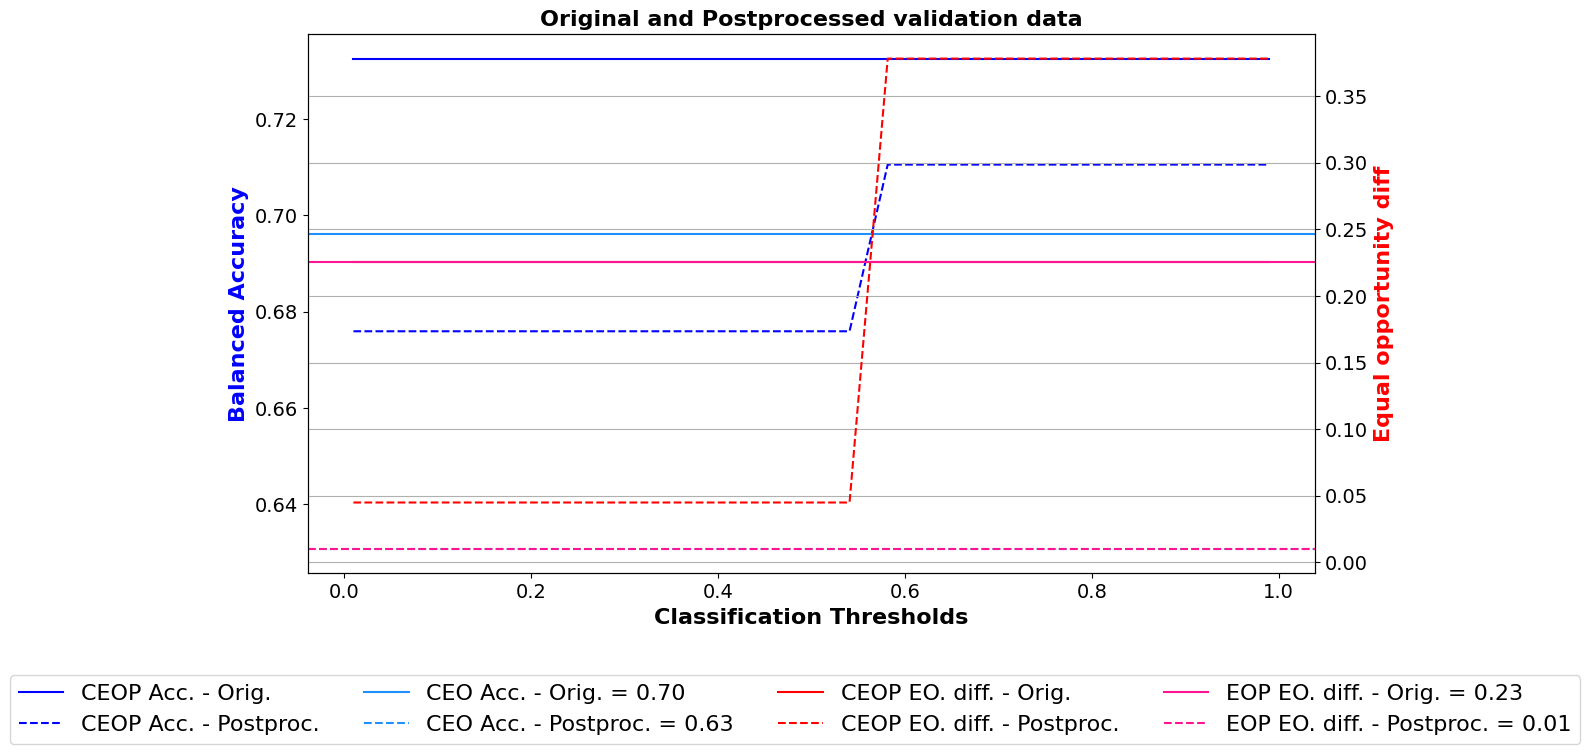

In [21]:
# Plotting the validation data results
eop_original_acc_valid, eop_original_avg_odds_valid = np.absolute(
    eop_handler.get_dataset("validation")["original_performance_metrics"]
)
eop_post_acc_valid, eop_post_avg_odds_valid = np.absolute(
    eop_handler.get_dataset("validation")["transformed_performance_metrics"]
)

ceop_original_acc_valid = np.array(ceop_original_acc_valid)
ceop_original_avg_odds_valid = np.array(ceop_original_avg_odds_valid)
ceop_post_acc_valid = np.array(ceop_post_acc_valid)
ceop_post_avg_odds_valid = np.array(ceop_post_avg_odds_valid)

fig, ax1 = plt.subplots(figsize=(13, 7))
ax1.plot(all_thresh, ceop_original_acc_valid, color="b")
ax1.plot(all_thresh, ceop_post_acc_valid, color="b", linestyle="dashed")
ax1.axhline(y=eop_original_acc_valid, color="dodgerblue", label="original accuracy")
ax1.axhline(
    y=eop_post_acc_valid,
    color="dodgerblue",
    linestyle="dashed",
    label=f"postprocessed accuracy",
)
ax1.set_title(
    "Original and Postprocessed validation data", fontsize=16, fontweight="bold"
)
ax1.set_xlabel("Classification Thresholds", fontsize=16, fontweight="bold")
ax1.set_ylabel("Balanced Accuracy", color="b", fontsize=16, fontweight="bold")
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(ceop_original_avg_odds_valid), color="r")
ax2.plot(all_thresh, np.abs(ceop_post_avg_odds_valid), color="r", linestyle="dashed")
ax2.axhline(
    y=eop_original_avg_odds_valid, color="deeppink", label="original equalized odds"
)
ax2.axhline(
    y=eop_post_avg_odds_valid,
    color="deeppink",
    linestyle="dashed",
    label="postprocessed equalized odds",
)
ax2.set_ylabel("Equal opportunity diff", color="r", fontsize=16, fontweight="bold")
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

fig.legend(
    [
        "CEOP Acc. - Orig.",
        "CEOP Acc. - Postproc.",
        f"CEO Acc. - Orig. = {eop_original_acc_valid:.2f}",
        f"CEO Acc. - Postproc. = {eop_post_acc_valid:.2f}",
        "CEOP EO. diff. - Orig.",
        "CEOP EO. diff. - Postproc.",
        f"EOP EO. diff. - Orig. = {eop_original_avg_odds_valid:.2f}",
        f"EOP EO. diff. - Postproc. = {eop_post_avg_odds_valid:.2f}",
    ],
    fontsize=16,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.15),
)

plt.show()

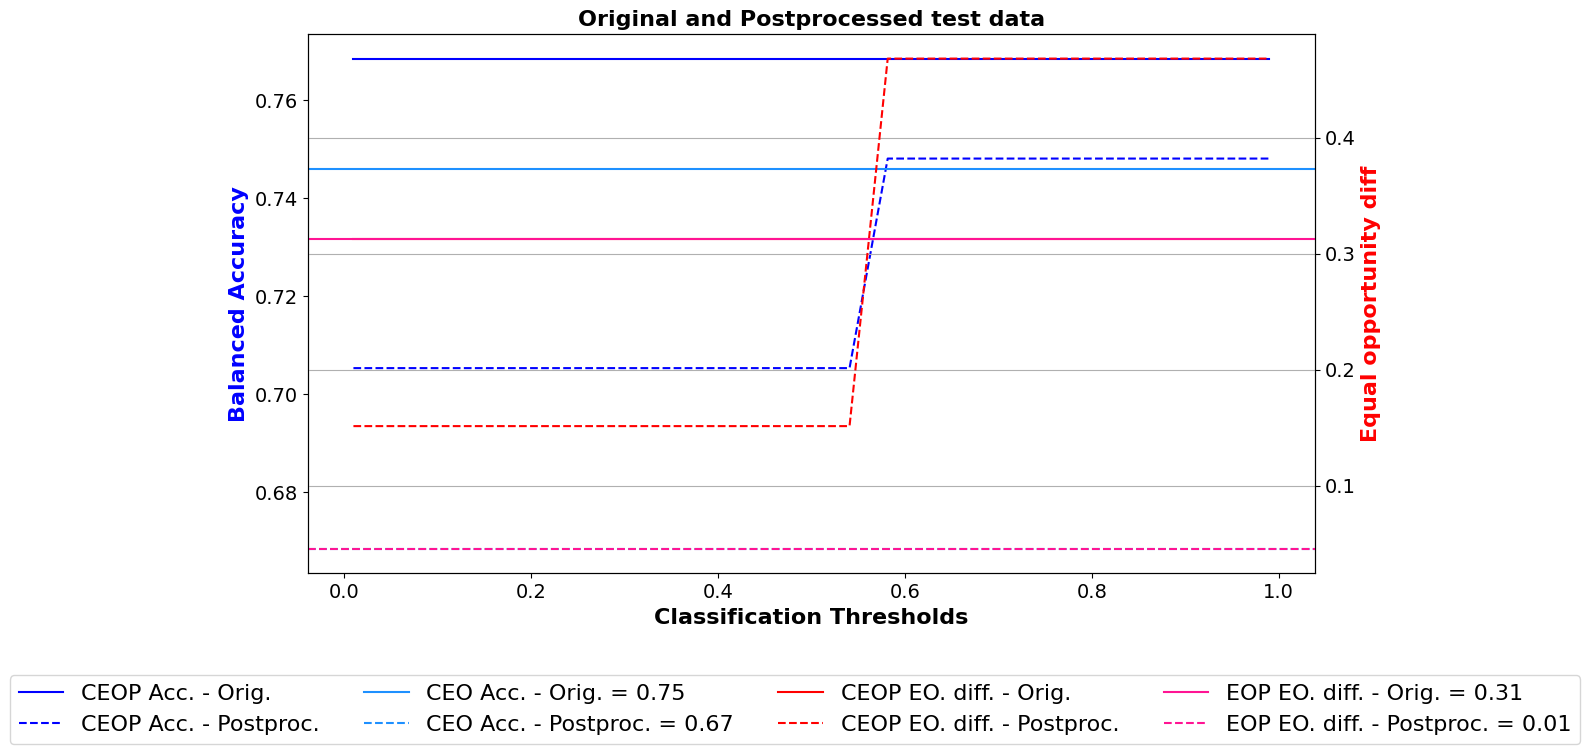

In [22]:
# Plotting the test data results
eop_original_acc_test, eop_original_avg_odds_test = np.absolute(
    eop_handler.get_dataset("test")["original_performance_metrics"]
)
eop_post_acc_test, eop_post_avg_odds_test = np.absolute(
    eop_handler.get_dataset("test")["transformed_performance_metrics"]
)

ceop_original_acc_test = np.array(ceop_original_acc_test)
ceop_original_avg_odds_test = np.array(ceop_original_avg_odds_test)
ceop_post_acc_test = np.array(ceop_post_acc_test)
ceop_post_avg_odds_test = np.array(ceop_post_avg_odds_test)

fig, ax1 = plt.subplots(figsize=(13, 7))
ax1.plot(all_thresh, ceop_original_acc_test, color="b")
ax1.plot(all_thresh, ceop_post_acc_test, color="b", linestyle="dashed")
ax1.axhline(y=eop_original_acc_test, color="dodgerblue", label="original accuracy")
ax1.axhline(
    y=eop_post_acc_test, color="dodgerblue", linestyle="dashed", label=f"postprocessed accuracy"
)
ax1.set_title(
    "Original and Postprocessed test data", fontsize=16, fontweight="bold"
)
ax1.set_xlabel("Classification Thresholds", fontsize=16, fontweight="bold")
ax1.set_ylabel("Balanced Accuracy", color="b", fontsize=16, fontweight="bold")
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(ceop_original_avg_odds_test), color="r")
ax2.plot(all_thresh, np.abs(ceop_post_avg_odds_test), color="r", linestyle="dashed")
ax2.axhline(
    y=eop_original_avg_odds_test, color="deeppink", label="original equalized odds"
)
ax2.axhline(
    y=eop_post_avg_odds_test,
    color="deeppink",
    linestyle="dashed",
    label="postprocessed equalized odds",
)
ax2.set_ylabel("Equal opportunity diff", color="r", fontsize=16, fontweight="bold")
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

fig.legend(
    [
        "CEOP Acc. - Orig.",
        "CEOP Acc. - Postproc.",
        f"CEO Acc. - Orig. = {eop_original_acc_test:.2f}",
        f"CEO Acc. - Postproc. = {eop_post_acc_test:.2f}",
        "CEOP EO. diff. - Orig.",
        "CEOP EO. diff. - Postproc.",
        f"EOP EO. diff. - Orig. = {eop_original_avg_odds_test:.2f}",
        f"EOP EO. diff. - Postproc. = {eop_post_avg_odds_valid:.2f}",
    ],
    fontsize=16,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.15),
)

plt.show()